In [8]:
# Add project root to path so we can import modules

import os, sys
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [9]:
import numpy as np
import math
import matplotlib.pyplot as plt

## Rough Heston / Rough fOU Variance

We model the instantaneous variance on a uniform grid $t_i = i\,\Delta t$ as:

$$
v_{t_i} = v_0
+ \underbrace{\int_0^{t_i} K(t_i-s)\,\phi(s)\,ds}_{\text{deterministic Volterra}}
+ \underbrace{\int_0^{t_i} K(t_i-s)\,\psi(s)\,dW_s}_{\text{stochastic Volterra}}.
$$

The **fractional kernel** is:

$$
K(t) = \frac{t^{H-\frac12}}{\Gamma\left(H+\frac12\right)}, \quad 0 < H < \frac12,
$$

and the **integrands** are:

$$
\phi(s) = \kappa\,[\theta - v_s], \qquad \psi(s) = \xi\sqrt{v_s}.
$$

This is the **rough** version of an Ornstein–Uhlenbeck variance process.


## Why precompute weights?

At each time step $i$, both integrals require values of $K(t_i - s)$ across all past cells.

We can precompute two weight vectors:

- Deterministic part:
$$
w^{(dt)}_{i-j} \approx \int_{t_j}^{t_{j+1}} K(t_i - s)\,ds
$$

- Stochastic part:
$$
w^{(dW)}_{i-j} \approx K\left(t_i - \frac{t_j + t_{j+1}}{2}\right)
$$

This transforms the integration into **vector multiplications and sums**, avoiding explicit loops over past cells for each path.


In [10]:
def precompute_weights(n_steps: int, dt: float, H: float):
    """Precompute deterministic and stochastic weights for the Volterra kernel."""
    n = np.arange(1, n_steps + 1)
    t_mid = (n - 0.5) * dt
    w_dW_mid = t_mid**(H - 0.5) / math.gamma(H + 0.5)
    Hp = H + 0.5
    t_right = n * dt
    t_left  = (n - 1) * dt
    w_dt_exact = (t_right**Hp - t_left**Hp) / (math.gamma(H + 0.5) * Hp)
    return w_dt_exact, w_dW_mid


## Deterministic Volterra term

At step $i$, for each path $p$:

$$
\text{term\_dt}[p] =
\sum_{j=0}^{i-1} \kappa\,\big(\theta - v_{p,j}\big) \cdot w^{(dt)}_{i-j}.
$$

In code:

```python
term_dt = (phi * wdti).sum(axis=1)


## Stochastic Volterra term

At step $i$, for each path $p$:

$$
\text{term\_sto}[p] =
\sum_{j=0}^{i-1} \xi\,\sqrt{v_{p,j}} \cdot \Delta W_{p,j} \cdot w^{(dW)}_{i-j}.
$$

In code:

```python
term_dW = (psi * dW[:, :i] * wdWi).sum(axis=1)


In [11]:
def simulate_variance_direct(n_paths: int, n_steps: int, T: float,
                             v0: float, kappa: float, theta: float, xi: float, H: float,
                             seed: int = 1):
    """Simulate variance paths under rough Heston/fOU dynamics using direct O(n^2) convolution."""
    rng = np.random.default_rng(seed)
    dt = T / n_steps
    w_dt, w_dW = precompute_weights(n_steps, dt, H)

    v = np.full((n_paths, n_steps + 1), v0, dtype=float)
    dW = rng.standard_normal(size=(n_paths, n_steps)) * np.sqrt(dt)

    for i in range(1, n_steps + 1):
        wdti = w_dt[:i][::-1]
        wdWi = w_dW[:i][::-1]

        phi = kappa * (theta - v[:, :i])
        psi = xi * np.sqrt(np.maximum(v[:, :i], 0.0))

        term_dt = (phi * wdti).sum(axis=1)
        term_dW = (psi * dW[:, :i] * wdWi).sum(axis=1)

        v[:, i] = v0 + term_dt + term_dW
        v[:, i] = np.maximum(v[:, i], 1e-12)

    t = np.linspace(0.0, T, n_steps + 1)
    return t, v


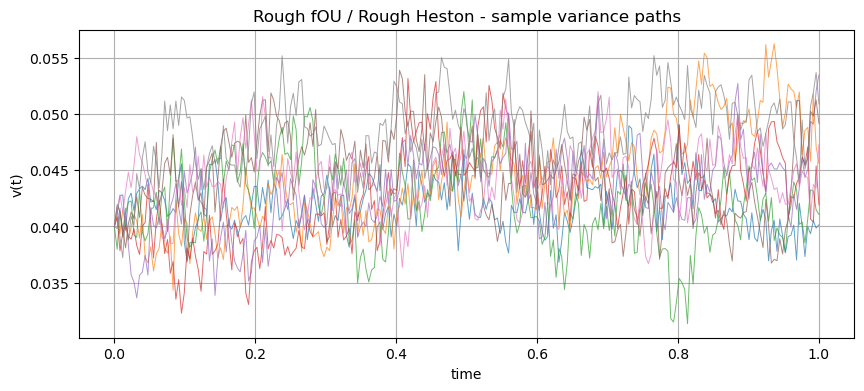

In [12]:
t, v = simulate_variance_direct(n_paths=10000, n_steps=252, T=1.0,
                                v0=0.04, kappa=1.0, theta=0.05, xi=0.02, H=0.1)

plt.figure(figsize=(10, 4))
for i in range(8):
    plt.plot(t, v[i], lw=0.7, alpha=0.7)
plt.title("Rough fOU / Rough Heston - sample variance paths")
plt.xlabel("time")
plt.ylabel("v(t)")
plt.grid(True)
plt.show()

## Interpretation 

This simulation illustrates how *rough volatility* modifies a standard Heston-style variance process.

- **Two Volterra integrals**:  
  - The **deterministic term** shifts variance toward the long-run mean $\theta$ at a speed $\kappa$, modulated by the fractional kernel $K(t)$, introducing *long memory* into the drift.  
  - The **stochastic term** injects noise proportional to $\xi \sqrt{v_s}$, also convolved with $K(t)$, so past shocks decay slowly when $H < 0.5$.

- **Variable meanings inside the loop**:  
  - `phi` contains $\phi(s) = \kappa \, (\theta - v_s)$ for all past time steps $j < i$.  
  - `psi` contains $\psi(s) = \xi \, \sqrt{v_s}$ for all past $j$.  
  - `dW` stores the Brownian increments $\Delta W_j$ for all paths and time steps.  
  - `wdti` are the **deterministic weights** $K_{\Delta t}$ for each lag $i - j$.  
  - `wdWi` are the **midpoint stochastic weights** $K_{dW}$, used in the stochastic Volterra term.

- **Numerical structure**:  
  - We discretise the integrals cell-by-cell on a uniform time grid.  
  - The weight vectors $w_{\Delta t}$ and $w_{dW}$ are precomputed for efficiency.  
  - Complexity is $O(n_{\text{steps}}^2)$ per path; FFT-based methods can reduce this.

- **Practical note for interviews**:  
  - You can emphasise that this is *Dupire-consistent* when combined with a leverage function, enabling exact calibration to the market implied vol surface.  
  - The fractional kernel arises from the autocorrelation structure of realised variance, as shown in Gatheral–Jaisson–Rosenbaum (2018).  


## Visual check: the kernel and its weights are decreasing

We plot three things:

1) The fractional kernel
$$
K(t) = \frac{t^{H-\tfrac12}}{\Gamma\!\left(H+\tfrac12\right)}
$$
on a dense time grid. For \(0 < H < \tfrac12\), this is strictly decreasing in \(t\).

2) The **midpoint weights** \(w_{dW}[n] = K\big((n-\tfrac12)\,\Delta t\big)\), which are samples of \(K\) at cell midpoints.

3) The **cell-integrated weights** \(w_{dt}[n] \approx \int_{(n-1)\Delta t}^{n\Delta t} K(u)\,du\), which also decay with the lag index.


In [13]:
import matplotlib.pyplot as plt

def plot_kernel_and_weights(model):
    """
    Plot the fractional kernel K(t) and the precomputed deterministic/stochastic weights.

    Args:
        model (RoughHestonVolterra): A fitted/initialised model instance.
    """
    t_cont = np.linspace(model.dt / 2, model.T, 400)
    K_cont = K_cont = t_cont**(model.H - 0.5) / math.gamma(model.H + 0.5)
    
    # Continuous kernel K(t)
    plt.figure(figsize=(7,3))
    plt.plot(t_cont, K_cont)
    plt.title("Fractional kernel K(t)")
    plt.xlabel("t")
    plt.ylabel("K(t)")
    plt.grid(True)
    plt.show()
    
    # Stochastic midpoint weights
    plt.figure(figsize=(7,3))
    plt.plot(model.w_dW, label=r"$w_{dW}$ (stochastic midpoint)", marker="o")
    plt.title("Stochastic midpoint weights $w_{dW}$ from model")
    plt.xlabel("Lag index")
    plt.ylabel("Weight value")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Deterministic cell-integrated weights
    plt.figure(figsize=(7,3))
    plt.plot(model.w_dt, label=r"$w_{\Delta t}$ (deterministic cell-integrated)", marker="s", color="orange")
    plt.title(r"Deterministic cell-integrated weights $w_{\Delta t}$ from model")
    plt.xlabel("Lag index")
    plt.ylabel("Weight value")
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure(figsize=(7,3))
    plt.loglog(t_cont, K_cont)
    plt.title("K(t) on log-log scale (slope ≈ H - 1/2)")
    plt.xlabel("t (log)")
    plt.ylabel("K(t) (log)")
    plt.grid(True, which="both")
    plt.show()

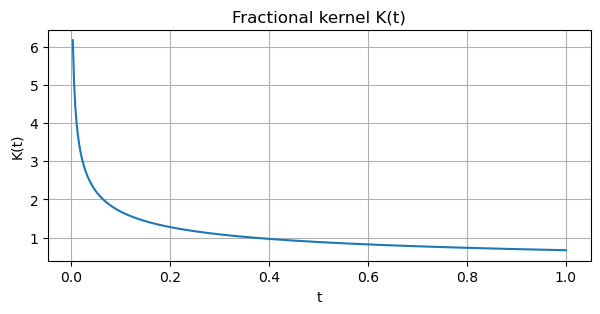

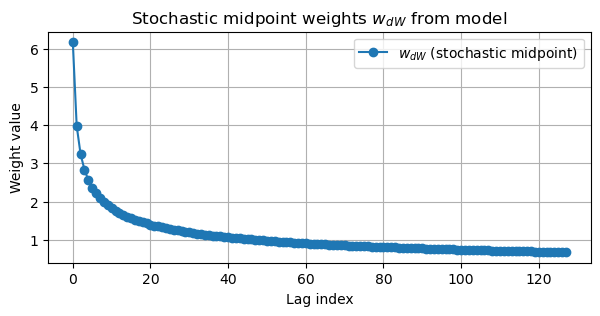

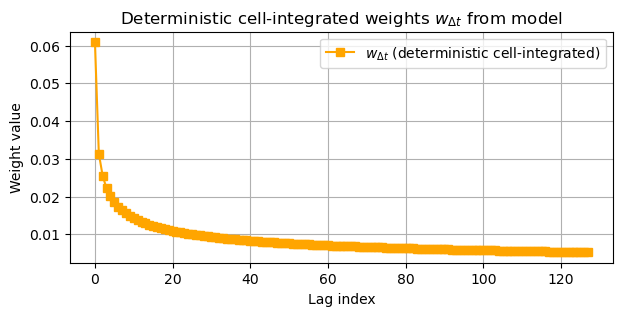

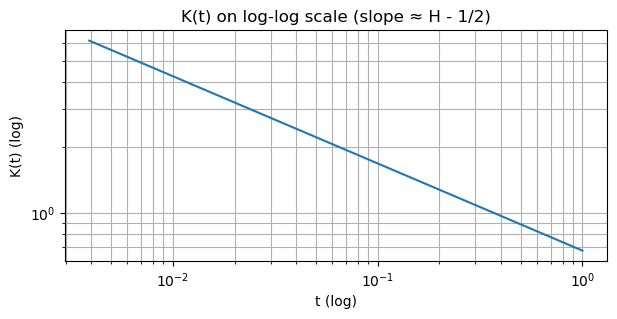

In [14]:
from models.rough_heston_volterra import RoughHestonVolterra

m = RoughHestonVolterra(
    v0=0.04, kappa=1.0, theta=0.05, xi=0.2, H=0.1,
    T=1.0, n_steps=128, n_paths=1000, seed=42
)

res = m.generate_paths()

plot_kernel_and_weights(m)


In [15]:
import numpy as np

# using your model instance m
n = np.arange(1, len(m.w_dW)+1, dtype=float)
t_mid = (n - 0.5) * m.dt
x = np.log(t_mid)
y = np.log(m.w_dW)

# simple OLS slope on log–log
slope, intercept = np.polyfit(x, y, 1)
H_est = slope + 0.5
print(f"log-log slope ≈ {slope:.4f},  implied H ≈ {H_est:.4f} (true H = {m.H})")


log-log slope ≈ -0.4000,  implied H ≈ 0.1000 (true H = 0.1)


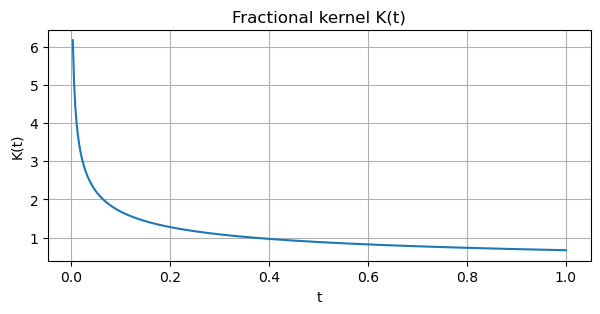

AttributeError: 'RoughHestonVolterra' object has no attribute 'plot_paths'

In [21]:
from models.rough_heston_volterra import RoughHestonVolterra

m = RoughHestonVolterra(
    v0=0.04, kappa=1.0, theta=0.05, xi=0.2, H=0.1,
    T=1.0, n_steps=128, n_paths=1000, seed=42
)

m.generate_paths()
m.plot_kernel()
m.plot_midpoint_weights()
m.plot_cell_weights()
m.plot_kernel_loglog()
m.plot_paths(n_paths_to_show=12, res=res)

